https://colab.research.google.com/drive/1zD9hl7v3f0zZV-5d80XK8Qb_61mQba-N

In [ ]:
! pip install bigartm
! pip install pyarrow
! pip install razdel
! pip install pymorphy3

In [ ]:
import typing as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from artm import BatchVectorizer, LDA, ARTM, TopTokensScore, PerplexityScore, DecorrelatorPhiRegularizer

import re  # очистка мусора
from razdel import tokenize as razdel_tokenize  # токенизация
from pymorphy3 import MorphAnalyzer  # лемматизация
import nltk
# from nltk.stem import WordNetLemmatizer  # лемматизация  # с русским не работало
from nltk.corpus import stopwords  # удаление стоп-слов

# nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train = pd.read_parquet('0000_train.parquet', 'pyarrow')
test = pd.read_parquet('0000_test.parquet', 'pyarrow')
# train = test

In [ ]:
train = train[['text', 'topic']].loc[:2000]
test = test[['text', 'topic']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,topic
0,Сладострастник в течение трех лет преследовал ...,incident
1,Буквально за час до боя курантов в подземном п...,incident
2,"Там они покатались на лыжах и снегоходах, пооб...",politics
3,Сосед расстрелял соседа из-за претензий по пов...,incident
4,Причиной трагедии специалисты считают нарушени...,incident
...,...,...
1996,.Сводный оркестр — поистине белая кость военно...,politics
1997,Эту горькую правду знает весь Междуреченск. Зд...,incident
1998,8 мая президент Медведев поставил свою подпись...,politics
1999,Учительница истории Плетнева рассказала собрав...,editions


## Предобработка

In [ ]:
train['topic'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['incident', 'politics', 'social', 'science', 'sport', 'culture',
       'auto', 'economics', 'editions'], dtype=object)

In [ ]:
le = LabelEncoder()
train['topic'] = le.fit_transform(train['topic'])

train['topic'].unique()

array([4, 5, 7, 6, 8, 1, 0, 2, 3])

In [ ]:
train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,topic
0,Сладострастник в течение трех лет преследовал ...,4
1,Буквально за час до боя курантов в подземном п...,4
2,"Там они покатались на лыжах и снегоходах, пооб...",5
3,Сосед расстрелял соседа из-за претензий по пов...,4
4,Причиной трагедии специалисты считают нарушени...,4
...,...,...
1996,.Сводный оркестр — поистине белая кость военно...,5
1997,Эту горькую правду знает весь Междуреченск. Зд...,4
1998,8 мая президент Медведев поставил свою подпись...,5
1999,Учительница истории Плетнева рассказала собрав...,3


In [ ]:
def preprocess(doc: str) -> str:
    doc = doc.lower()
    doc = re.sub(r'[^а-яА-Я]+', ' ', doc)
    doc = re.sub(r' +', ' ', doc)
    words = [_.text for _ in razdel_tokenize(doc)]

    morph = MorphAnalyzer()
    stopwords_ = set(stopwords.words('russian'))

    words = [
        lemma for word in words
        if (lemma := morph.normal_forms(word)[0]) not in stopwords_
        and len(lemma) >= 3
    ]

    doc = ' '.join(words)

    return doc

In [ ]:
train['text'] = train['text'].apply(preprocess)
train.head(3)

,text,topic
0,сладострастник течение год преследовать подрос...,4
1,буквально час бой курант подземный переход ста...,4
2,покататься лыжа снегоход пообщаться отдыхать п...,5


In [ ]:
# train.to_csv('prepro_train_2k.csv', sep=';', encoding='utf-8', index=False)

## Векторизация

In [ ]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=20_000)
mx_train = cv.fit_transform(train['text']).toarray()

In [ ]:
mx_train.shape

(2001, 20000)

In [ ]:
np.unique(mx_train[212], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 17, 23]),
 array([19435,   431,    78,    23,    13,     7,     5,     4,     1,
            1,     1,     1]))

In [ ]:
vocab = cv.get_feature_names_out()
vocab

array(['абдулаев', 'абитуриент', 'абонент', ..., 'ящик', 'ёжик',
       'ёмкость'], dtype=object)

In [ ]:
vocab[1000:1200]

array(['будни', 'будников', 'будущее', 'будущее год', 'будущее наш',
       'будущий', 'будущий пенсия', 'буйный', 'буква', 'буквально',
       'буквально день', 'буквально каждый', 'буквально несколько',
       'буквальный', 'буквальный смысл', 'букет', 'букмекерский',
       'букмекерский контора', 'буллит', 'бульва', 'бульва район',
       'бульвар', 'бум', 'бумага', 'бумажка', 'бумажный', 'бунин',
       'бункер', 'бунт', 'бунтовать', 'буратино', 'бурка', 'бурлить',
       'бурный', 'бурштейн', 'бурый', 'буря', 'бурятский', 'бутерброд',
       'бутовый', 'буторин', 'бутылка', 'бутылка водка', 'бутырка',
       'бутырки', 'бутырский', 'бутырский тюрьма', 'буфет', 'бухгалтер',
       'бухгалтерия', 'бухта', 'буш', 'бушевать', 'буэнос',
       'буэнос айрес', 'бывало', 'бывать', 'бывать разный',
       'бывать ситуация', 'бывать случай', 'бывать это', 'бывший',
       'бывший беспризорник', 'бывший владелец', 'бывший глава',
       'бывший жена', 'бывший коллега', 'бывший муж', 'бывши

$n_{wd}$ - частота документа "в токене"

In [ ]:
n_wd = mx_train.T
n_wd.shape

(20000, 2001)

In [ ]:
bv = BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=vocab, target_folder='batches')

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


## LDA

https://bigartm.readthedocs.io/en/stable/api_references/python_interface/lda_model.html

In [ ]:
lda = LDA(
    num_topics=9,
    alpha=0.1,
    beta=0.1,
    num_document_passes=5,
    dictionary=bv.dictionary,
    cache_theta=True,
)

In [ ]:
lda.fit_offline(bv, num_collection_passes=10)

In [ ]:
lda.phi_

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
август,0.000007,0.000307,0.000003,0.000078,0.000111,0.000192,0.000156,0.000063,0.000073
август год,0.000004,0.000149,0.000002,0.000073,0.000092,0.000128,0.000027,0.000029,0.000041
бабушка,0.000050,0.000598,0.000164,0.000002,0.000046,0.000003,0.000003,0.000250,0.000288
берег,0.000180,0.000092,0.000094,0.000024,0.000002,0.000446,0.000004,0.000065,0.000161
быстрый,0.000136,0.000030,0.000030,0.000197,0.000298,0.000096,0.000090,0.000133,0.000163
...,...,...,...,...,...,...,...,...,...
ход экипаж человек,0.000002,0.000002,0.000102,0.000001,0.000001,0.000002,0.000001,0.000002,0.000001
экипаж человек,0.000002,0.000002,0.000102,0.000001,0.000001,0.000002,0.000001,0.000002,0.000001
новошип,0.000003,0.000002,0.000003,0.000001,0.000001,0.000096,0.000001,0.000002,0.000001
танкер,0.000003,0.000002,0.000002,0.000001,0.000001,0.000097,0.000002,0.000002,0.000001


In [ ]:
np.sum(np.array(lda.phi_)[:, 0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.99995637

In [ ]:
lda.get_theta()

,2000,0,1,2,3,4,5,6,7,8,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
topic_0,0.002371,0.001392,0.051165,0.004693,0.001421,0.028389,0.281991,0.029223,0.008643,0.023396,...,0.014263,0.001062,0.001454,0.001884,0.002463,0.000908,0.001103,0.047719,0.000746,0.316844
topic_1,0.003847,0.981380,0.657943,0.003894,0.624220,0.853826,0.002823,0.317782,0.001615,0.001603,...,0.002954,0.000591,0.002640,0.000761,0.040300,0.002001,0.000620,0.026475,0.000506,0.072765
topic_2,0.032748,0.010156,0.255611,0.025765,0.359830,0.076493,0.184322,0.002758,0.013441,0.002647,...,0.006616,0.000723,0.002816,0.000740,0.541242,0.000966,0.001075,0.589790,0.000809,0.054254
topic_3,0.019536,0.000953,0.001177,0.594930,0.001556,0.003522,0.003508,0.002637,0.001230,0.019117,...,0.001208,0.666307,0.885888,0.001898,0.190455,0.024893,0.003146,0.001724,0.038283,0.458766
topic_4,0.811240,0.000926,0.001203,0.006231,0.001610,0.003057,0.059642,0.002554,0.005550,0.035830,...,0.002492,0.003625,0.003362,0.168355,0.000993,0.615427,0.017202,0.003973,0.918412,0.003220
topic_5,0.006256,0.001224,0.001878,0.343261,0.001929,0.004598,0.007231,0.002634,0.919318,0.019669,...,0.003093,0.001002,0.010999,0.757693,0.043256,0.000976,0.506923,0.003249,0.028670,0.022583
topic_6,0.001853,0.001163,0.028853,0.005315,0.006278,0.027459,0.453908,0.637964,0.005177,0.610116,...,0.000874,0.000722,0.030712,0.067576,0.011255,0.002713,0.000542,0.000734,0.001192,0.016572
topic_7,0.035273,0.001266,0.001087,0.007522,0.001713,0.001363,0.003855,0.002010,0.043382,0.163725,...,0.036347,0.054684,0.057861,0.000592,0.026062,0.186099,0.453321,0.196530,0.001818,0.052815
topic_8,0.086878,0.001540,0.001084,0.008391,0.001443,0.001291,0.002720,0.002439,0.001644,0.123898,...,0.932152,0.271284,0.004267,0.000500,0.143973,0.166017,0.016069,0.129805,0.009564,0.002180


In [ ]:
np.sum(np.array(lda.get_theta())[:, 0])

0.99999994

In [ ]:
lda.transform(bv)

,2000,0,1,2,3,4,5,6,7,8,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
topic_0,0.002012,0.001177,0.023148,0.004733,0.001404,0.030978,0.328705,0.007770,0.005715,0.023739,...,0.007135,0.001138,0.001350,0.001990,0.001935,0.000935,0.001193,0.036745,0.000642,0.294143
topic_1,0.004191,0.988714,0.738297,0.003877,0.635407,0.866333,0.002492,0.313046,0.001489,0.001695,...,0.002097,0.000612,0.002413,0.000764,0.024091,0.001769,0.000616,0.027053,0.000495,0.067017
topic_2,0.020291,0.003396,0.223744,0.033855,0.349354,0.069637,0.128348,0.002795,0.006646,0.002472,...,0.002979,0.000717,0.002263,0.000783,0.568421,0.000912,0.000990,0.574495,0.000623,0.062740
topic_3,0.005334,0.000935,0.001210,0.612268,0.001576,0.003420,0.003206,0.002595,0.001153,0.013639,...,0.001203,0.683145,0.903564,0.001250,0.194190,0.007472,0.002503,0.001429,0.015457,0.479471
topic_4,0.858369,0.000896,0.001206,0.007801,0.001629,0.003904,0.046598,0.002411,0.005284,0.031955,...,0.002030,0.004465,0.003453,0.149408,0.000960,0.649654,0.012969,0.003776,0.950102,0.003581
topic_5,0.005411,0.001122,0.001934,0.315333,0.001920,0.006126,0.004674,0.002475,0.949495,0.009666,...,0.002588,0.001039,0.006811,0.787123,0.056374,0.000938,0.480602,0.002088,0.020197,0.036347
topic_6,0.001328,0.001073,0.008309,0.005419,0.005517,0.016962,0.479442,0.663973,0.003807,0.630559,...,0.000827,0.000735,0.031585,0.057601,0.009825,0.002083,0.000550,0.000706,0.000994,0.017883
topic_7,0.026159,0.001227,0.001079,0.008015,0.001731,0.001355,0.003821,0.002253,0.024755,0.205265,...,0.020634,0.061709,0.045097,0.000583,0.022757,0.162097,0.489557,0.236903,0.001257,0.036708
topic_8,0.076906,0.001459,0.001073,0.008699,0.001461,0.001285,0.002713,0.002682,0.001657,0.081009,...,0.960506,0.246440,0.003464,0.000497,0.121447,0.174140,0.011020,0.116806,0.010234,0.002109


In [ ]:
lda.phi_['topic_5'].nlargest(n=11)

это          0.012378
который      0.007323
всё          0.005669
свой         0.004881
мочь         0.004784
весь         0.004624
год          0.004574
президент    0.004307
война        0.004222
дело         0.004014
наш          0.004013
Name: topic_5, dtype: float32

Спасибо nltk за такие стоп-слова

In [ ]:
lda.perplexity_last_value

3835.736083984375

In [ ]:
lda.perplexity_value

[19834.5234375,
 5798.10009765625,
 5617.47900390625,
 5239.0517578125,
 4759.75048828125,
 4377.97900390625,
 4134.4150390625,
 3986.03466796875,
 3894.875,
 3835.736083984375]

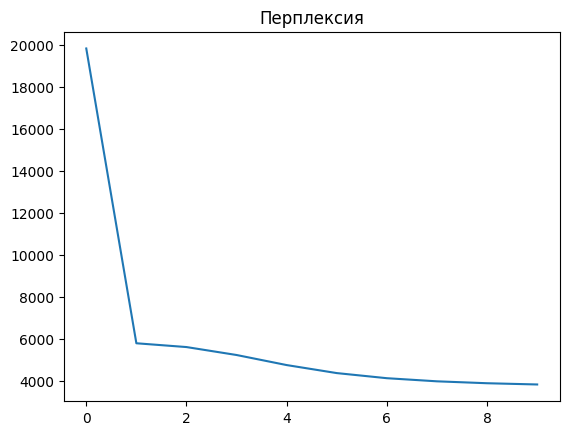

In [ ]:
plt.plot(lda.perplexity_value)
plt.title('Перплексия');

In [ ]:
ldas = []
topics_grid = [1, *range(3, 13)]

for topics in tqdm(topics_grid):
    lda_i = LDA(num_topics=topics, alpha=0.1, beta=0.1, num_document_passes=7, dictionary=bv.dictionary, cache_theta=False)
    lda_i.fit_offline(bv, num_collection_passes=11)
    ldas.append(lda_i)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 11/11 [01:34<00:00,  8.60s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


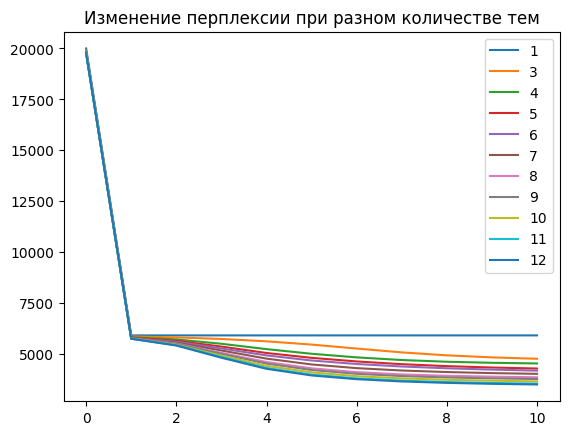

In [ ]:
plt.title('Изменение перплексии при разном количестве тем')
for lda_i, topics in zip(ldas, topics_grid):
    plt.plot(lda_i.perplexity_value, label=topics)
plt.legend()

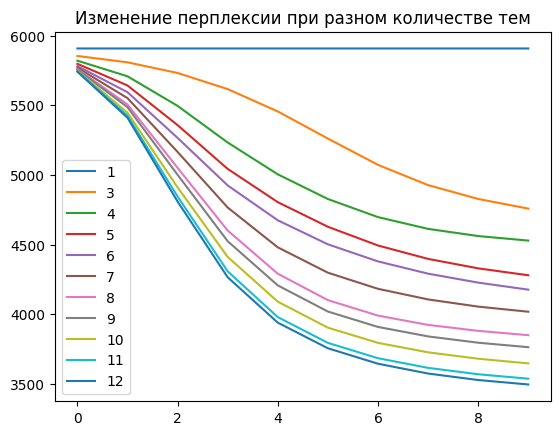

In [ ]:
plt.title('Изменение перплексии при разном количестве тем')
for lda_i, topics in zip(ldas, topics_grid):
    plt.plot(lda_i.perplexity_value[1:], label=topics)
plt.legend()

topics=6

In [ ]:
lda6 = ldas[4];
lda6.num_topics

6

In [ ]:
for i in range(lda6.num_topics):
    print(lda.phi_[f'topic_{i}'].nlargest(n=11))
    print()

это        0.009941
который    0.006274
человек    0.006082
год        0.005864
весь       0.004850
время      0.004362
работа     0.003944
мочь       0.003920
всё        0.003397
должный    0.003306
также      0.002969
Name: topic_0, dtype: float32

год         0.009720
летний      0.009041
дом         0.005969
мужчина     0.005701
свой        0.005438
стать       0.005012
который     0.004889
квартира    0.004604
день        0.004533
женщина     0.004272
ребёнок     0.004190
Name: topic_1, dtype: float32

который      0.008528
человек      0.007664
стать        0.006471
свой         0.005151
весь         0.004905
день         0.004126
время        0.004094
слово        0.004007
несколько    0.003858
машина       0.003825
мочь         0.003789
Name: topic_2, dtype: float32

это        0.010210
год        0.008822
который    0.008296
наш        0.005376
весь       0.005174
москва     0.005157
всё        0.004718
россия     0.004670
команда    0.004145
первый     0.004136
игра       0.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# lda6.get_top_tokens()

In [ ]:
test['text'] = test['text'].apply(preprocess)

In [ ]:
test.to_csv('prepro_test.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
test_n_wd = cv.transform(test['text']).toarray().T
test_bv = BatchVectorizer(data_format='bow_n_wd', n_wd=test_n_wd, vocabulary=vocab, target_folder='test_batches')

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [ ]:
lda6.transform(test_bv)

,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.262527,0.042610,0.111230,0.065502,0.112902,0.058270,0.189447,0.056551,0.079183,0.127286,...,0.329196,0.086798,0.102362,0.201681,0.022696,0.044880,0.008785,0.183346,0.157478,0.051275
topic_1,0.007242,0.028414,0.007525,0.049759,0.295837,0.353460,0.151442,0.112819,0.014112,0.007468,...,0.160749,0.566544,0.466797,0.424989,0.020260,0.121252,0.008816,0.059722,0.436173,0.023605
topic_2,0.075411,0.054053,0.450072,0.148291,0.088231,0.205379,0.007030,0.020925,0.019831,0.054627,...,0.011224,0.148545,0.057763,0.078194,0.024852,0.016571,0.020834,0.035919,0.029014,0.053253
topic_3,0.153276,0.083270,0.127481,0.123227,0.056092,0.049117,0.404369,0.199113,0.103458,0.415466,...,0.041357,0.045864,0.018952,0.010937,0.159720,0.114142,0.860470,0.111037,0.053102,0.050338
topic_4,0.363825,0.654664,0.274410,0.019344,0.269345,0.100817,0.187834,0.339421,0.750611,0.282740,...,0.174521,0.054420,0.089362,0.082123,0.670108,0.124000,0.037447,0.060106,0.023088,0.184635
topic_5,0.137719,0.136989,0.029282,0.593877,0.177593,0.232957,0.059878,0.271172,0.032806,0.112414,...,0.282953,0.097829,0.264763,0.202075,0.102363,0.579156,0.063648,0.549869,0.301145,0.636894


In [ ]:
lda6.perplexity_last_value

4177.13427734375

In [ ]:
lda6.perplexity_value

[19813.06640625,
 5781.36767578125,
 5594.01123046875,
 5265.9599609375,
 4924.86376953125,
 4674.853515625,
 4502.3623046875,
 4379.7919921875,
 4291.8037109375,
 4227.5107421875,
 4177.13427734375]

## Модель общего вида с регуляризаторами

### Пока без регуляризатора

In [ ]:
model = ARTM(num_topics=10, show_progress_bars=True)

In [ ]:
model.scores.add(PerplexityScore(name='perplexity_score'))
model.scores.add(TopTokensScore(name='top_tokens_score'))

model.num_document_passes = 11

In [ ]:
model.scores

[perplexity_score, top_tokens_score]

In [ ]:
model.initialize(dictionary=bv.dictionary)

In [ ]:
model.master.clear_score_array_cache()

In [ ]:
model.fit_offline(bv, num_collection_passes=29)

Pass: 100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


In [ ]:
model.score_tracker['perplexity_score'].value

[19698.904296875,
 5675.92626953125,
 5258.73779296875,
 4660.93408203125,
 4211.37109375,
 3947.091552734375,
 3797.513916015625,
 3707.837158203125,
 3649.960205078125,
 3610.095703125,
 3580.83935546875,
 3558.462158203125,
 3540.8818359375,
 3526.605712890625,
 3515.001708984375,
 3505.247314453125,
 3496.598388671875,
 3488.510986328125,
 3481.294189453125,
 3475.078125,
 3469.54443359375,
 3464.407470703125,
 3459.61669921875,
 3455.32421875,
 3451.446533203125,
 3447.828369140625,
 3444.36572265625,
 3441.03076171875,
 3437.962890625]

In [ ]:
pprint(model.score_tracker['top_tokens_score'].last_tokens)

{'topic_0': ['это',
             'который',
             'год',
             'весь',
             'время',
             'новый',
             'человек',
             'день',
             'мочь',
             'также'],
 'topic_1': ['ребёнок',
             'год',
             'дом',
             'свой',
             'семья',
             'это',
             'родитель',
             'всё',
             'который',
             'весь'],
 'topic_2': ['это',
             'который',
             'человек',
             'мочь',
             'весь',
             'стать',
             'год',
             'врач',
             'всё',
             'время'],
 'topic_3': ['это',
             'который',
             'команда',
             'игра',
             'спорт',
             'наш',
             'россия',
             'год',
             'первый',
             'матч'],
 'topic_4': ['это',
             'год',
             'россия',
             'который',
             'страна',
             'свой'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


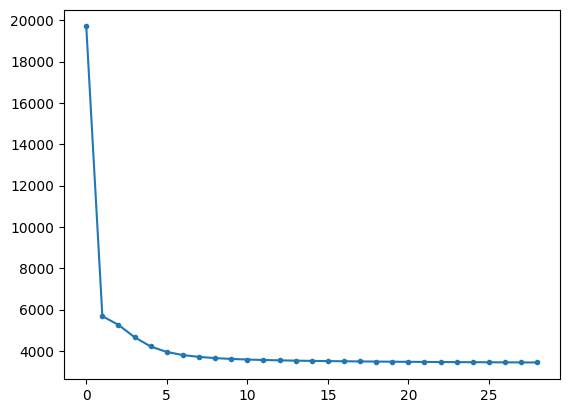

In [ ]:
plt.plot(model.score_tracker['perplexity_score'].value, marker='.')

In [ ]:
model.transform(test_bv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.265966,0.028279,0.063683,0.039574,0.011351,0.013754,0.073199,0.051852,0.058283,0.314097,...,0.057193,0.036363,0.039522,0.022248,0.044066,0.005504,0.004724,0.084395,0.071236,0.018985
topic_1,0.000969,0.014692,0.001251,0.023642,0.051924,0.284494,0.233952,0.011895,0.000948,0.001198,...,0.286982,0.604243,0.245129,0.213591,0.020064,0.020475,0.006020,0.070679,0.346296,0.002059
topic_2,0.254394,0.015639,0.600342,0.001078,0.016901,0.019309,0.119081,0.003912,0.032530,0.037498,...,0.229493,0.067284,0.024682,0.054717,0.012488,0.001289,0.012213,0.089138,0.005405,0.000447
topic_3,0.001881,0.065987,0.003187,0.088234,0.009020,0.002448,0.149477,0.109363,0.003086,0.197822,...,0.004790,0.018324,0.000142,0.000111,0.056248,0.088340,0.815530,0.035675,0.008286,0.000155
topic_4,0.265995,0.515907,0.080120,0.007513,0.173636,0.127669,0.039523,0.295151,0.674668,0.227048,...,0.087661,0.030669,0.032102,0.007713,0.699210,0.153366,0.025617,0.026834,0.002765,0.209907
topic_5,0.022801,0.187147,0.025073,0.058715,0.028665,0.020151,0.024001,0.040000,0.045438,0.045829,...,0.002147,0.003852,0.051179,0.124022,0.091141,0.091880,0.024847,0.394618,0.010747,0.160853
topic_6,0.074526,0.129483,0.097001,0.003479,0.350322,0.042219,0.291235,0.163861,0.138601,0.119029,...,0.003152,0.001578,0.123377,0.211811,0.025938,0.000085,0.004160,0.006313,0.005207,0.000399
topic_7,0.029024,0.014646,0.003020,0.124730,0.037174,0.044477,0.059417,0.057319,0.043284,0.047415,...,0.123250,0.044843,0.007524,0.048885,0.014239,0.077729,0.048291,0.051641,0.075274,0.034962
topic_8,0.078903,0.017188,0.008636,0.522669,0.181155,0.236070,0.009792,0.212280,0.000840,0.001682,...,0.204391,0.073990,0.400882,0.223411,0.024666,0.521545,0.037314,0.237430,0.465631,0.541069
topic_9,0.005543,0.011030,0.117688,0.130366,0.139852,0.209408,0.000324,0.054367,0.002321,0.008384,...,0.000941,0.118854,0.075461,0.093490,0.011942,0.039785,0.021283,0.003278,0.009154,0.031163


In [ ]:
model.get_score('perplexity_score').value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3922.90234375

### like lda6

In [ ]:
model6 = ARTM(
    num_topics=6,
    num_document_passes=7,
    dictionary=bv.dictionary,
    scores=[PerplexityScore(name='perplexity_score'), TopTokensScore(name='top_tokens_score')],
)
model6.master.clear_score_array_cache()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model6.fit_offline(bv, num_collection_passes=11)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


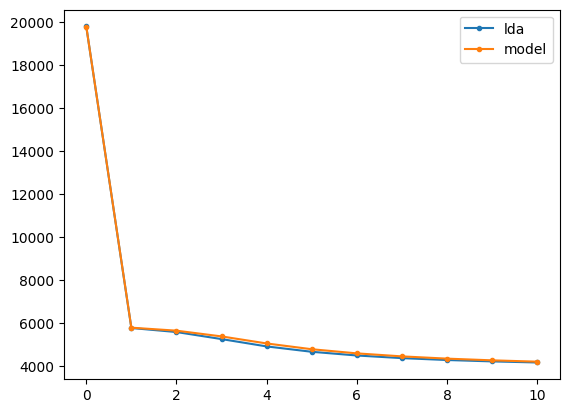

In [ ]:
plt.plot(lda6.perplexity_value, marker='.', label='lda')
plt.plot(model6.score_tracker['perplexity_score'].value, marker='.', label='model')
plt.legend()

In [ ]:
pprint(model6.score_tracker['top_tokens_score'].last_tokens)

{'topic_0': ['это',
             'год',
             'человек',
             'который',
             'весь',
             'всё',
             'мочь',
             'время',
             'работа',
             'должный'],
 'topic_1': ['год',
             'дом',
             'свой',
             'ребёнок',
             'квартира',
             'летний',
             'стать',
             'это',
             'день',
             'суд'],
 'topic_2': ['который',
             'стать',
             'человек',
             'сотрудник',
             'свой',
             'милиция',
             'машина',
             'мужчина',
             'несколько',
             'милиционер'],
 'topic_3': ['это',
             'год',
             'который',
             'всё',
             'наш',
             'весь',
             'москва',
             'первый',
             'россия',
             'игра'],
 'topic_4': ['год',
             'это',
             'россия',
             'который',
             'мочь

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model6.transform(test_bv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.341205,0.051172,0.163098,0.054677,0.164711,0.061993,0.242525,0.080965,0.121977,0.140048,...,0.305396,0.071467,0.079070,0.163521,0.028134,0.049400,0.008757,0.188363,0.132126,0.058072
topic_1,0.005781,0.029124,0.003861,0.064575,0.273725,0.337057,0.154974,0.119015,0.013302,0.006253,...,0.186052,0.557079,0.478420,0.441490,0.023859,0.151767,0.008082,0.057214,0.452764,0.031540
topic_2,0.082440,0.060169,0.456505,0.156306,0.092461,0.207057,0.008081,0.021555,0.022335,0.060308,...,0.013880,0.159127,0.062130,0.085204,0.033496,0.011152,0.031093,0.044717,0.034779,0.052302
topic_3,0.114694,0.087772,0.107318,0.147951,0.043963,0.043750,0.370418,0.192265,0.095316,0.401987,...,0.035486,0.050745,0.015485,0.005893,0.163102,0.127094,0.827892,0.111469,0.060766,0.047861
topic_4,0.314780,0.618241,0.237911,0.019840,0.247811,0.122197,0.168144,0.334728,0.701318,0.271836,...,0.202215,0.068309,0.122489,0.079491,0.665762,0.158046,0.043689,0.068773,0.032754,0.209743
topic_5,0.141101,0.153522,0.031307,0.556651,0.177330,0.227946,0.055859,0.251471,0.045751,0.119569,...,0.256971,0.093272,0.242407,0.224401,0.085647,0.502541,0.080487,0.529464,0.286810,0.600480


In [ ]:
model6.get_score('perplexity_score').value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4272.88037109375

## DecorrelatorPhiRegularizer. Различие тем для повышения интерпретируемости

In [ ]:
model_decor = ARTM(
    num_topics=6,
    num_document_passes=7,
    dictionary=bv.dictionary,
    scores=[PerplexityScore(name='perplexity_score'), TopTokensScore(name='top_tokens_score')],
)
model_decor.regularizers.add(DecorrelatorPhiRegularizer(tau=5e5))
model_decor.master.clear_score_array_cache()

In [ ]:
model_decor.fit_offline(bv, num_collection_passes=11)

In [ ]:
model_decor.score_tracker['perplexity_score'].value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[19811.353515625,
 5796.46630859375,
 5662.693359375,
 5389.654296875,
 5062.388671875,
 4793.443359375,
 4601.0302734375,
 4460.22265625,
 4353.958984375,
 4272.59814453125,
 4208.52978515625]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


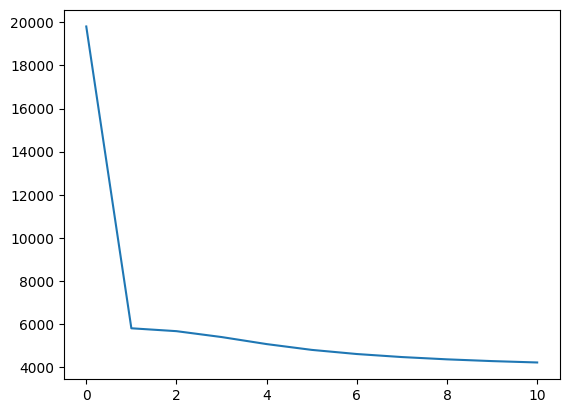

In [ ]:
plt.plot(model_decor.score_tracker['perplexity_score'].value)

In [ ]:
pprint(model_decor.score_tracker['top_tokens_score'].last_tokens)

{'topic_0': ['это',
             'человек',
             'год',
             'весь',
             'который',
             'всё',
             'мочь',
             'время',
             'работа',
             'рубль'],
 'topic_1': ['год',
             'дом',
             'квартира',
             'летний',
             'ребёнок',
             'свой',
             'стать',
             'суд',
             'день',
             'женщина'],
 'topic_2': ['который',
             'стать',
             'сотрудник',
             'человек',
             'машина',
             'милиция',
             'милиционер',
             'мужчина',
             'несколько',
             'место'],
 'topic_3': ['это',
             'год',
             'который',
             'всё',
             'наш',
             'москва',
             'весь',
             'первый',
             'россия',
             'игра'],
 'topic_4': ['год',
             'это',
             'россия',
             'который',
             'с

In [ ]:
model_decor.transform(test_bv)
model_decor.get_score('perplexity_score').value

4271.1416015625